# 모델 전반 소개
1. NLP와 non_NLP를 따로 만들어야 했다 (training set이 나눠져 있음)
2. 만든 후 합칠 때 Validation set을 따로 수집해야 했다
3. 모델이 사용자 Input을 받고 빠르게 값을 내야 함으로 훈련시킨 모델을 저장 (Pickle)

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "MS.png")

# NLP(DL)
1. word2vec embedding
2. GRU
3. Logistic Regression와 비슷한 성능 (Accuracy: 66.20)
4. 학습시간 28분 가량 (Google Colab GPU)
5. Data 출처: https://www.kaggle.com/oscarvilla/kickstarter-nlp

In [0]:
# Import a Pretrained WordVector(Word2Vec) from Google
import gensim

In [0]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
ds = pd.read_csv('/content/drive/My Drive/df_text_eng.csv', index_col='Unnamed: 0')

In [0]:
ds.head()

,blurb,state
1,"Using their own character, users go on educati...",0
2,"MicroFly is a quadcopter packed with WiFi, 6 s...",1
3,"A small indie press, run as a collective for a...",0
4,Zylor is a new baby cosplayer! Back this kicks...,0
5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,0


In [0]:
ds['state'] = ds['state'].apply(lambda x: 0 if x == 'failed' else 1)

In [0]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [47]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [48]:
>>> import nltk
>>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
blurbs = list()
lines = ds['blurb'].values.tolist()

In [0]:
#turn NaN values into string
for i in range(len(lines)):
    if type(lines[i]) == float:
        lines[i] = ''

In [51]:
for line in tqdm(lines):
    tokens = word_tokenize(line)
    # to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    blurbs.append(words)

100%|██████████| 215513/215513 [01:42<00:00, 2103.18it/s]


In [0]:
#train word2vec model
model = gensim.models.Word2Vec(sentences=blurbs, size=300, window =5, workers=4, min_count=1)

In [53]:
# export the word embedding
model.wv.save_word2vec_format('blurb_word2vec.txt', binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [54]:
import os

embeddings_index= {}
f = open(os.path.join('', 'blurb_word2vec.txt'), encoding = 'utf-8')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

117446it [00:10, 10822.55it/s]


In [0]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [0]:
# Set the max length

length = list()

for i in range(len(blurbs)):
    length.append(len(blurbs[i]))

max_length = max(length)

In [57]:
VALIDATION_SPLIT = 0.2

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(blurbs)
sequences = tokenizer_obj.texts_to_sequences(blurbs)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

blurb_pad = pad_sequences(sequences, maxlen=max_length)
state =  ds['state'].values
print('Shape of blurb tensor:', blurb_pad.shape)
print('Shape of state tensor:', state.shape)

# split the data into a training set and a validation set
indices = np.arange(blurb_pad.shape[0])
np.random.shuffle(indices)
blurb_pad = blurb_pad[indices]
state = state[indices]
num_validation_samples = int(VALIDATION_SPLIT * blurb_pad.shape[0])

X_train_pad = blurb_pad[:-num_validation_samples]
y_train = state[:-num_validation_samples]
X_test_pad = blurb_pad[-num_validation_samples:]
y_test = state[-num_validation_samples:]

Found 117445 unique tokens.
Shape of blurb tensor: (215513, 26)
Shape of state tensor: (215513,)


In [58]:
print('Shape of X_train_pad tensor:', X_train_pad.shape)
print('Shape of y_train tensor:', y_train.shape)

print('Shape of X_test_pad tensor:', X_test_pad.shape)
print('Shape of y_test tensor:', y_test.shape)

Shape of X_train_pad tensor: (172411, 26)
Shape of y_train tensor: (172411,)
Shape of X_test_pad tensor: (43102, 26)
Shape of y_test tensor: (43102,)


In [59]:
EMBEDDING_DIM =300
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in tqdm(word_index.items()):
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 117445/117445 [00:16<00:00, 6925.82it/s]


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Summary of the built model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 26, 300)           35233800  
_________________________________________________________________
gru (GRU)                    (None, 32)                31968     
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 35,265,801
Trainable params: 32,001
Non-trainable params: 35,233,800
_________________________________________________________________
None


In [61]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)

True

In [62]:
print('Train...')

model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train...
Train on 172411 samples, validate on 43102 samples
Epoch 1/25
172411/172411 - 66s - loss: 0.6408 - acc: 0.6283 - val_loss: 0.6255 - val_acc: 0.6464
Epoch 2/25
172411/172411 - 64s - loss: 0.6240 - acc: 0.6477 - val_loss: 0.6203 - val_acc: 0.6507
Epoch 3/25
172411/172411 - 64s - loss: 0.6188 - acc: 0.6530 - val_loss: 0.6169 - val_acc: 0.6557
Epoch 4/25
172411/172411 - 63s - loss: 0.6150 - acc: 0.6568 - val_loss: 0.6143 - val_acc: 0.6597
Epoch 5/25
172411/172411 - 63s - loss: 0.6125 - acc: 0.6592 - val_loss: 0.6122 - val_acc: 0.6610
Epoch 6/25
172411/172411 - 63s - loss: 0.6103 - acc: 0.6609 - val_loss: 0.6130 - val_acc: 0.6600
Epoch 7/25
172411/172411 - 63s - loss: 0.6089 - acc: 0.6629 - val_loss: 0.6109 - val_acc: 0.6610
Epoch 8/25
172411/172411 - 63s - loss: 0.6068 - acc: 0.6652 - val_loss: 0.6128 - val_acc: 0.6586
Epoch 9/25
172411/172411 - 64s - loss: 0.6062 - acc: 0.6652 - val_loss: 0.6103 - val_acc: 0.6616
Epoch 10/25
172411/172411 - 63s - loss: 0.6053 - acc: 0.6657 - val_

In [63]:
print('Testing...')
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
43102/43102 [==============================] - 5s 111us/sample - loss: 0.6090 - acc: 0.6620
Test score: 0.6089751882750243
Test accuracy: 0.662011
Accuracy: 66.20%


# NLP (ML)
1. 자체 data 이용한 vectorization
2. Logistic Regression (0.676)
3. 학습시간 약 0.25초 (local CPU)

In [6]:
import pandas as pd
import numpy as np
data = pd.read_csv("df_text_eng.csv")
data.head()

,Unnamed: 0,blurb,state
0,1,"Using their own character, users go on educati...",failed
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful
2,3,"A small indie press, run as a collective for a...",failed
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed


In [7]:
del data['Unnamed: 0'] 
from io import StringIO
data['state_id'] = data['state'].factorize()[0]
state_id_df = data[['state', 'state_id']].drop_duplicates().sort_values('state_id')
state_to_id = dict(state_id_df.values)
id_to_state = dict(state_id_df[['state_id', 'state']].values)
data.head()

,blurb,state,state_id
0,"Using their own character, users go on educati...",failed,0
1,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful,1
2,"A small indie press, run as a collective for a...",failed,0
3,Zylor is a new baby cosplayer! Back this kicks...,failed,0
4,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed,0


<function matplotlib.pyplot.show(*args, **kw)>

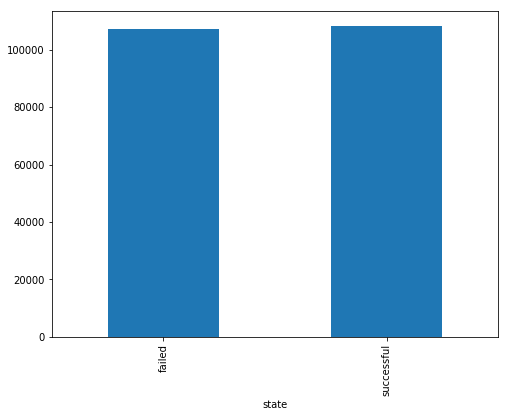

In [8]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('state').blurb.count().plot.bar(ylim=0)
plt.show

In [9]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
data['blurb'] = data['blurb'].apply(lambda x: clean(x))

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
x_train, x_test, y_train, y_test = train_test_split(data['blurb'], data['state'], train_size=0.7, random_state=42)
vectorizer = TfidfVectorizer().fit(x_train)
x_train_v = vectorizer.transform(x_train)
x_test_v  = vectorizer.transform(x_test)

In [11]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time
entries = []
def train():
    models = {
        "LogisticRegression": LogisticRegression(),
        "SGDClassifier": SGDClassifier(),
        "Multinomial":MultinomialNB(),
        "LinearSVC": LinearSVC(),
    }
    for model in models:
        print("training model"+model)
        start = time()
        models[model].fit(x_train_v, y_train)
        end = time()
        print("trained in {} secs".format(end-start))
        y_pred = models[model].predict(x_test_v)
        entries.append((model,accuracy_score(y_test, y_pred)))

In [13]:
train()

training modelLogisticRegression


D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


trained in 3.0187430381774902 secs
training modelSGDClassifier
trained in 0.507366418838501 secs
training modelMultinomial
trained in 0.3729386329650879 secs
training modelLinearSVC
trained in 2.969576597213745 secs


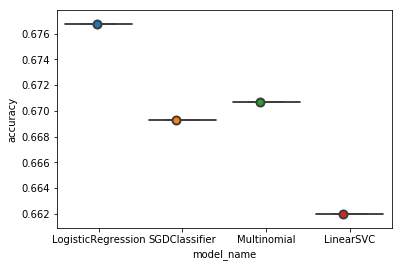

In [14]:
cv_df = pd.DataFrame(entries, columns=['model_name','accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


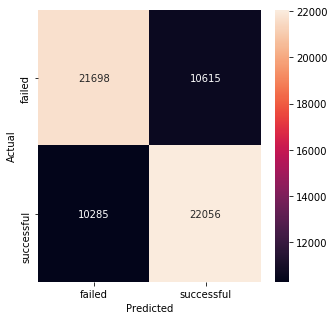

In [15]:
model = LogisticRegression()
model.fit(x_train_v, y_train)
y_pred = model.predict(x_test_v)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=state_id_df.state.values, yticklabels=state_id_df.state.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      failed       0.68      0.67      0.67     32313
  successful       0.68      0.68      0.68     32341

    accuracy                           0.68     64654
   macro avg       0.68      0.68      0.68     64654
weighted avg       0.68      0.68      0.68     64654



In [17]:
import pickle

In [18]:
filename = 'NLP_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Non-NLP
1. 중간고사 대비 발전한 부분
    - 범주형 변수 처리 (Forcat 사용)
    - 구간별 Binnarization 삭제
    - 모델 변경 (Xgboost -> Catboost)
2. Data 출처: https://www.kaggle.com/kemical/kickstarter-projects

## Feature Selection

<BarContainer object of 8 artists>

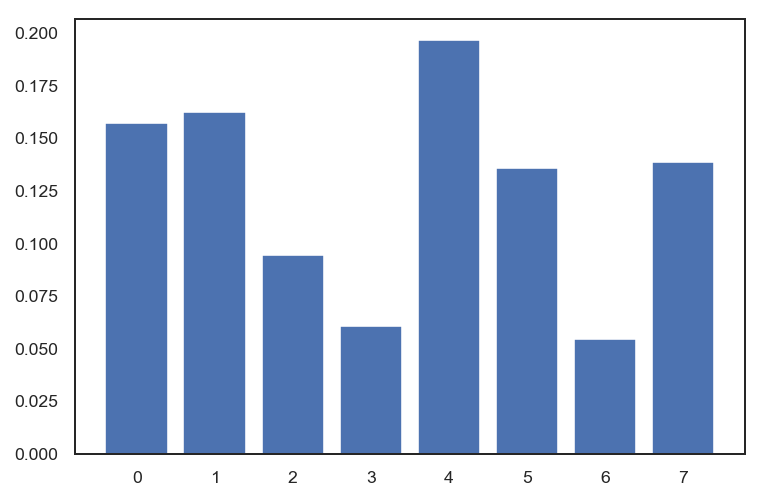

In [31]:
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)

In [32]:
train.dtypes

category            int16
main_category        int8
currency             int8
country              int8
usd_goal_real     float64
launched_year       int32
launched_month      int32
term                int64
state               int64
dtype: object

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_columns',999)
pd.set_option('max_rows',200)

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
import seaborn as sns
sns.set() 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 
sns.set_style(style='white')
sns.set_context(context ='paper')

import datetime
import os
from functools import reduce
import json

In [2]:
# Data for training loaded from the database
projects = pd.read_csv('ks-projects-201801.csv')

In [3]:
projects['state_new'] = projects.apply(lambda x: 'success' if x['usd_pledged_real'] >= x['usd_goal_real']
                                       else 'failed', axis = 1)

In [4]:
projects['launched_year'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[0], axis = 1)
projects['launched_month'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1], axis = 1)
projects['launched_day'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[2], axis = 1)
projects['launched_date'] = projects.apply(lambda x: x['launched'].split(" ")[0].split("-")[1] + x['launched'].split(" ")[0].split("-")[2], axis = 1)

In [5]:
projects['deadline_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['deadline'], "%Y-%m-%d").date(), axis = 1)
projects['launched_dt'] = projects.apply(lambda x: datetime.datetime.strptime(x['launched'].split(" ")[0], "%Y-%m-%d").date(), axis = 1)

In [6]:
projects['term'] = projects.apply(lambda x: int(str(x['deadline_dt'] - x['launched_dt']).split(" ")[0]), axis = 1)
projects['term_str'] = projects.apply(lambda x: str(x['term']), axis = 1)

In [7]:
# launch 날짜가 1970년으로 되어있는 row는 삭제
projects_new = projects[lambda x: x['term'] < 100]

In [8]:
projects_new = projects_new.reset_index().drop(['index'], axis = 1)

In [9]:
projects_new['term_str'] = projects_new.apply(lambda x: x['term_str'] if len(x['term_str']) != 1
                                             else '0' + x['term_str'], axis = 1)

In [10]:
# binnarize the dependent variable
projects_new['state_bin'] = projects_new['state_new'].apply(lambda x: 0 if x == 'failed' else 1)

In [11]:
# 10만원 이하로 펀딩 받는 경우는 지움
projects_fin = projects_new[projects_new['usd_goal_real'] > 100]

In [12]:
projects_fin = projects_new[projects_new['country'].isin(['US', 'BR', 'CA', 'AU', 'DE', 'FR', 'IT', 'NL', 'ES'])]

In [13]:
projects_fin = projects_new[projects_new['currency'].isin(['USD', 'GBP', 'EUR', 'CAD', 'AUD'])]

In [14]:
# Creating the dataset
train_data = projects_fin[['category', 'main_category', 'currency', 'country', 'usd_goal_real', 'state_bin', 'launched_year', 'launched_month', 'term']].copy()

In [15]:
train = pd.DataFrame()

In [16]:
# Assigning a categorical type to categorical varibles and vectorizing the categories for simplification
train['category'] = train_data['category'].astype('category').cat.codes
train['main_category'] = train_data['main_category'].astype('category').cat.codes
train['currency'] = train_data['currency'].astype('category').cat.codes
train['country'] = train_data['country'].astype('category').cat.codes

In [17]:
# export labes for vectorizing

cat_c = train_data['category'].astype('category')
main_c = train_data['main_category'].astype('category')
curre_c = train_data['currency'].astype('category')
count_c = train_data['country'].astype('category')
cat_d = dict(enumerate(cat_c.cat.categories))
main_d = dict(enumerate(main_c.cat.categories))
curre_d = dict(enumerate(curre_c.cat.categories))
count_d = dict(enumerate(count_c.cat.categories))

cat = {y:x for x,y in cat_d.items()}
main = {y:x for x,y in main_d.items()}
curre = {y:x for x,y in curre_d.items()}
count = {y:x for x,y in count_d.items()}

cat_labels = {'category' : cat, 'main_category' : main, 'currency' : curre, 'country': count}
cat_json = json.dumps(cat_labels)
f = open("cat_labels.json","w")
f.write(cat_json)
f.close()

In [18]:
train[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state']] = train_data[['usd_goal_real', 'launched_year', 'launched_month', 'term', 'state_bin']]

In [19]:
train['launched_year'] = (train['launched_year']).astype('int')
train['launched_month'] = (train['launched_month']).astype('int')

In [20]:
x = train.iloc[:,:-1]
y = train.iloc[:,-1]

In [22]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [25]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [26]:
xgb_model = xgb.XGBClassifier(n_estimators=1000,
                        n_jobs=6,
                        max_depth=5,
                        learning_rate=0.1,
                        gamma = 0,
                        subsample = 0.8,
                        scale_pos_weight = 1,
                        min_child_weight=1,
                        colsample_bytree=0.8,
                        objective= 'binary:logistic',
                        nthread=4,
                        missing=-999,
                        seed=27,
                        tree_method='gpu_hist')

In [27]:
xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=-999, n_estimators=1000, n_jobs=6,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, tree_method='gpu_hist', verbosity=1)

In [28]:
prediction = xgb_model.predict(x_test)

In [29]:
from sklearn.metrics import accuracy_score, f1_score

## Xgboost Result

In [30]:
f1_score(y_test, prediction), accuracy_score(y_test, prediction)

(0.5403814992750945, 0.7085350134753883)

In [33]:
import catboost as cb

In [34]:
cb_clf = cb.CatBoostClassifier(task_type = 'GPU')

In [35]:
# Labelling the categorical features
cat_features= [0,1,2,3]

cb_clf.fit(x_train, y_train, cat_features)

Learning rate set to 0.080728


0:	learn: 0.6755262	total: 62.6ms	remaining: 1m 2s
1:	learn: 0.6610547	total: 100ms	remaining: 50.1s
2:	learn: 0.6491370	total: 137ms	remaining: 45.6s
3:	learn: 0.6386351	total: 178ms	remaining: 44.4s
4:	learn: 0.6297548	total: 216ms	remaining: 43s
5:	learn: 0.6225697	total: 256ms	remaining: 42.4s
6:	learn: 0.6160055	total: 296ms	remaining: 42s
7:	learn: 0.6111072	total: 338ms	remaining: 42s
8:	learn: 0.6061068	total: 376ms	remaining: 41.4s
9:	learn: 0.6020036	total: 416ms	remaining: 41.1s
10:	learn: 0.5983953	total: 456ms	remaining: 41s
11:	learn: 0.5953873	total: 498ms	remaining: 41s
12:	learn: 0.5927794	total: 540ms	remaining: 41s
13:	learn: 0.5904531	total: 581ms	remaining: 40.9s
14:	learn: 0.5884239	total: 621ms	remaining: 40.8s
15:	learn: 0.5866149	total: 666ms	remaining: 40.9s
16:	learn: 0.5849379	total: 707ms	remaining: 40.9s
17:	learn: 0.5835332	total: 747ms	remaining: 40.8s
18:	learn: 0.5819140	total: 785ms	remaining: 40.5s
19:	learn: 0.5805894	total: 823ms	remaining: 40.3s
2

161:	learn: 0.5555347	total: 5.99s	remaining: 31s
162:	learn: 0.5555080	total: 6.03s	remaining: 30.9s
163:	learn: 0.5554653	total: 6.07s	remaining: 30.9s
164:	learn: 0.5554249	total: 6.1s	remaining: 30.9s
165:	learn: 0.5553833	total: 6.14s	remaining: 30.8s
166:	learn: 0.5553578	total: 6.18s	remaining: 30.8s
167:	learn: 0.5553351	total: 6.22s	remaining: 30.8s
168:	learn: 0.5552925	total: 6.26s	remaining: 30.8s
169:	learn: 0.5552521	total: 6.3s	remaining: 30.8s
170:	learn: 0.5552105	total: 6.35s	remaining: 30.8s
171:	learn: 0.5551659	total: 6.38s	remaining: 30.7s
172:	learn: 0.5551375	total: 6.42s	remaining: 30.7s
173:	learn: 0.5550537	total: 6.46s	remaining: 30.7s
174:	learn: 0.5550107	total: 6.5s	remaining: 30.7s
175:	learn: 0.5549619	total: 6.55s	remaining: 30.7s
176:	learn: 0.5548874	total: 6.58s	remaining: 30.6s
177:	learn: 0.5548401	total: 6.62s	remaining: 30.6s
178:	learn: 0.5547751	total: 6.66s	remaining: 30.5s
179:	learn: 0.5547011	total: 6.69s	remaining: 30.5s
180:	learn: 0.554

325:	learn: 0.5503205	total: 12.1s	remaining: 25.1s
326:	learn: 0.5502967	total: 12.2s	remaining: 25s
327:	learn: 0.5502860	total: 12.2s	remaining: 25s
328:	learn: 0.5502615	total: 12.2s	remaining: 24.9s
329:	learn: 0.5502397	total: 12.3s	remaining: 24.9s
330:	learn: 0.5502235	total: 12.3s	remaining: 24.9s
331:	learn: 0.5501965	total: 12.3s	remaining: 24.8s
332:	learn: 0.5501733	total: 12.4s	remaining: 24.8s
333:	learn: 0.5501571	total: 12.4s	remaining: 24.8s
334:	learn: 0.5501312	total: 12.5s	remaining: 24.7s
335:	learn: 0.5501109	total: 12.5s	remaining: 24.7s
336:	learn: 0.5501002	total: 12.5s	remaining: 24.7s
337:	learn: 0.5500747	total: 12.6s	remaining: 24.6s
338:	learn: 0.5500670	total: 12.6s	remaining: 24.6s
339:	learn: 0.5500369	total: 12.6s	remaining: 24.5s
340:	learn: 0.5500025	total: 12.7s	remaining: 24.5s
341:	learn: 0.5499673	total: 12.7s	remaining: 24.5s
342:	learn: 0.5499459	total: 12.7s	remaining: 24.4s
343:	learn: 0.5499211	total: 12.8s	remaining: 24.4s
344:	learn: 0.54

486:	learn: 0.5469928	total: 18.2s	remaining: 19.1s
487:	learn: 0.5469725	total: 18.2s	remaining: 19.1s
488:	learn: 0.5469477	total: 18.2s	remaining: 19.1s
489:	learn: 0.5469328	total: 18.3s	remaining: 19s
490:	learn: 0.5469174	total: 18.3s	remaining: 19s
491:	learn: 0.5469082	total: 18.3s	remaining: 18.9s
492:	learn: 0.5469011	total: 18.4s	remaining: 18.9s
493:	learn: 0.5468917	total: 18.4s	remaining: 18.9s
494:	learn: 0.5468779	total: 18.5s	remaining: 18.8s
495:	learn: 0.5468656	total: 18.5s	remaining: 18.8s
496:	learn: 0.5468627	total: 18.5s	remaining: 18.7s
497:	learn: 0.5468494	total: 18.6s	remaining: 18.7s
498:	learn: 0.5468390	total: 18.6s	remaining: 18.7s
499:	learn: 0.5468120	total: 18.6s	remaining: 18.6s
500:	learn: 0.5467904	total: 18.7s	remaining: 18.6s
501:	learn: 0.5467682	total: 18.7s	remaining: 18.6s
502:	learn: 0.5467574	total: 18.8s	remaining: 18.5s
503:	learn: 0.5467461	total: 18.8s	remaining: 18.5s
504:	learn: 0.5467228	total: 18.8s	remaining: 18.5s
505:	learn: 0.54

646:	learn: 0.5444326	total: 24.2s	remaining: 13.2s
647:	learn: 0.5444199	total: 24.2s	remaining: 13.2s
648:	learn: 0.5444025	total: 24.3s	remaining: 13.1s
649:	learn: 0.5443744	total: 24.3s	remaining: 13.1s
650:	learn: 0.5443702	total: 24.4s	remaining: 13.1s
651:	learn: 0.5443518	total: 24.4s	remaining: 13s
652:	learn: 0.5443340	total: 24.4s	remaining: 13s
653:	learn: 0.5443194	total: 24.5s	remaining: 12.9s
654:	learn: 0.5443047	total: 24.5s	remaining: 12.9s
655:	learn: 0.5442796	total: 24.5s	remaining: 12.9s
656:	learn: 0.5442592	total: 24.6s	remaining: 12.8s
657:	learn: 0.5442296	total: 24.6s	remaining: 12.8s
658:	learn: 0.5442154	total: 24.7s	remaining: 12.8s
659:	learn: 0.5442063	total: 24.7s	remaining: 12.7s
660:	learn: 0.5441970	total: 24.7s	remaining: 12.7s
661:	learn: 0.5441866	total: 24.8s	remaining: 12.7s
662:	learn: 0.5441824	total: 24.8s	remaining: 12.6s
663:	learn: 0.5441748	total: 24.9s	remaining: 12.6s
664:	learn: 0.5441686	total: 24.9s	remaining: 12.5s
665:	learn: 0.54

806:	learn: 0.5422816	total: 30.2s	remaining: 7.23s
807:	learn: 0.5422670	total: 30.3s	remaining: 7.19s
808:	learn: 0.5422616	total: 30.3s	remaining: 7.15s
809:	learn: 0.5422535	total: 30.3s	remaining: 7.12s
810:	learn: 0.5422423	total: 30.4s	remaining: 7.08s
811:	learn: 0.5422314	total: 30.4s	remaining: 7.04s
812:	learn: 0.5422206	total: 30.5s	remaining: 7.01s
813:	learn: 0.5422077	total: 30.5s	remaining: 6.97s
814:	learn: 0.5421964	total: 30.5s	remaining: 6.93s
815:	learn: 0.5421808	total: 30.6s	remaining: 6.89s
816:	learn: 0.5421614	total: 30.6s	remaining: 6.86s
817:	learn: 0.5421500	total: 30.7s	remaining: 6.82s
818:	learn: 0.5421411	total: 30.7s	remaining: 6.78s
819:	learn: 0.5421293	total: 30.7s	remaining: 6.75s
820:	learn: 0.5421083	total: 30.8s	remaining: 6.71s
821:	learn: 0.5420899	total: 30.8s	remaining: 6.67s
822:	learn: 0.5420806	total: 30.8s	remaining: 6.63s
823:	learn: 0.5420707	total: 30.9s	remaining: 6.59s
824:	learn: 0.5420559	total: 30.9s	remaining: 6.56s
825:	learn: 

965:	learn: 0.5404113	total: 36.3s	remaining: 1.28s
966:	learn: 0.5403921	total: 36.4s	remaining: 1.24s
967:	learn: 0.5403831	total: 36.4s	remaining: 1.2s
968:	learn: 0.5403702	total: 36.4s	remaining: 1.17s
969:	learn: 0.5403610	total: 36.5s	remaining: 1.13s
970:	learn: 0.5403483	total: 36.5s	remaining: 1.09s
971:	learn: 0.5403436	total: 36.6s	remaining: 1.05s
972:	learn: 0.5403328	total: 36.6s	remaining: 1.01s
973:	learn: 0.5403218	total: 36.6s	remaining: 978ms
974:	learn: 0.5403132	total: 36.7s	remaining: 940ms
975:	learn: 0.5402943	total: 36.7s	remaining: 903ms
976:	learn: 0.5402797	total: 36.7s	remaining: 865ms
977:	learn: 0.5402674	total: 36.8s	remaining: 827ms
978:	learn: 0.5402500	total: 36.8s	remaining: 790ms
979:	learn: 0.5402420	total: 36.9s	remaining: 752ms
980:	learn: 0.5402235	total: 36.9s	remaining: 714ms
981:	learn: 0.5402117	total: 36.9s	remaining: 677ms
982:	learn: 0.5401984	total: 37s	remaining: 639ms
983:	learn: 0.5401920	total: 37s	remaining: 602ms
984:	learn: 0.540

In [36]:
y_pred = cb_clf.predict(x_test)

# Catboost Result

In [37]:
f1_score(y_test, y_pred), accuracy_score(y_test, y_pred)

(0.5419066081304521, 0.7103197137268688)

In [38]:
import pickle

filename = 'Non_nlp_model' # name to store model
pickle.dump(cb_clf, open(filename, 'wb')) # pickling